In [3]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from statsmodels.formula.api import ols

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [5]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [6]:
origin=load_data('cars')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기 : (50, 2)
행 개수 : 50개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


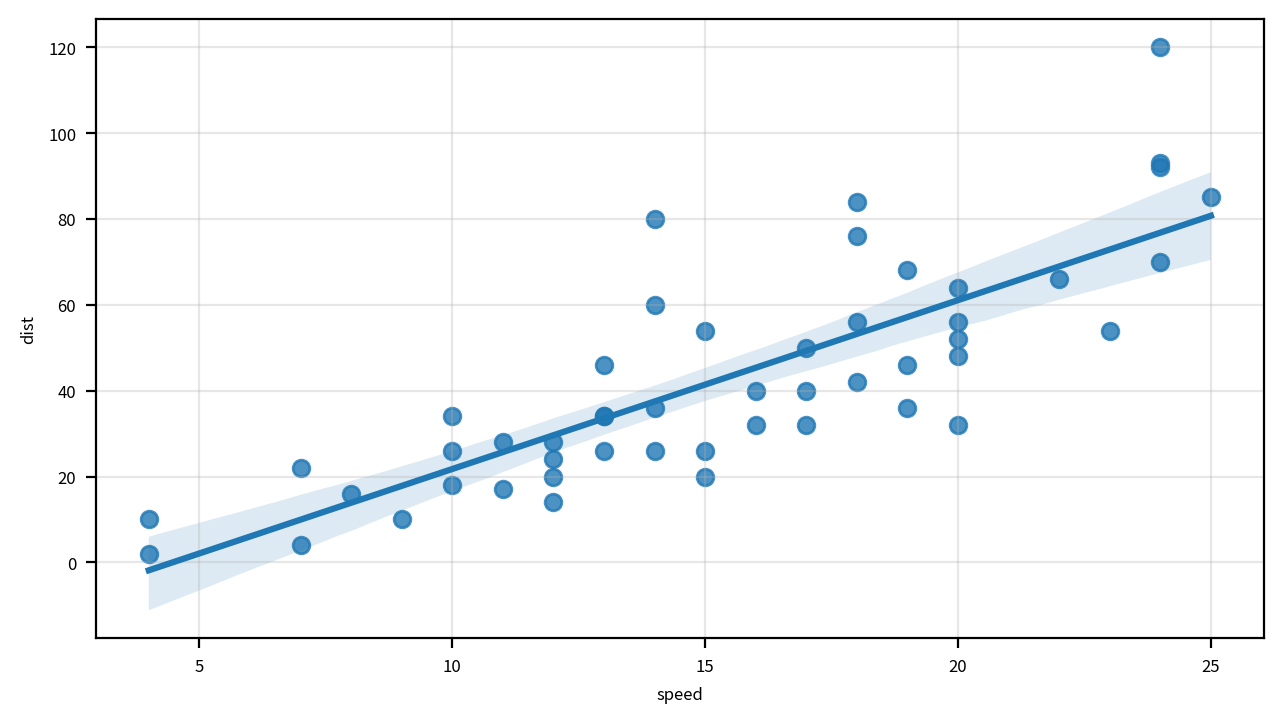

In [7]:
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='speed', y='dist')

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

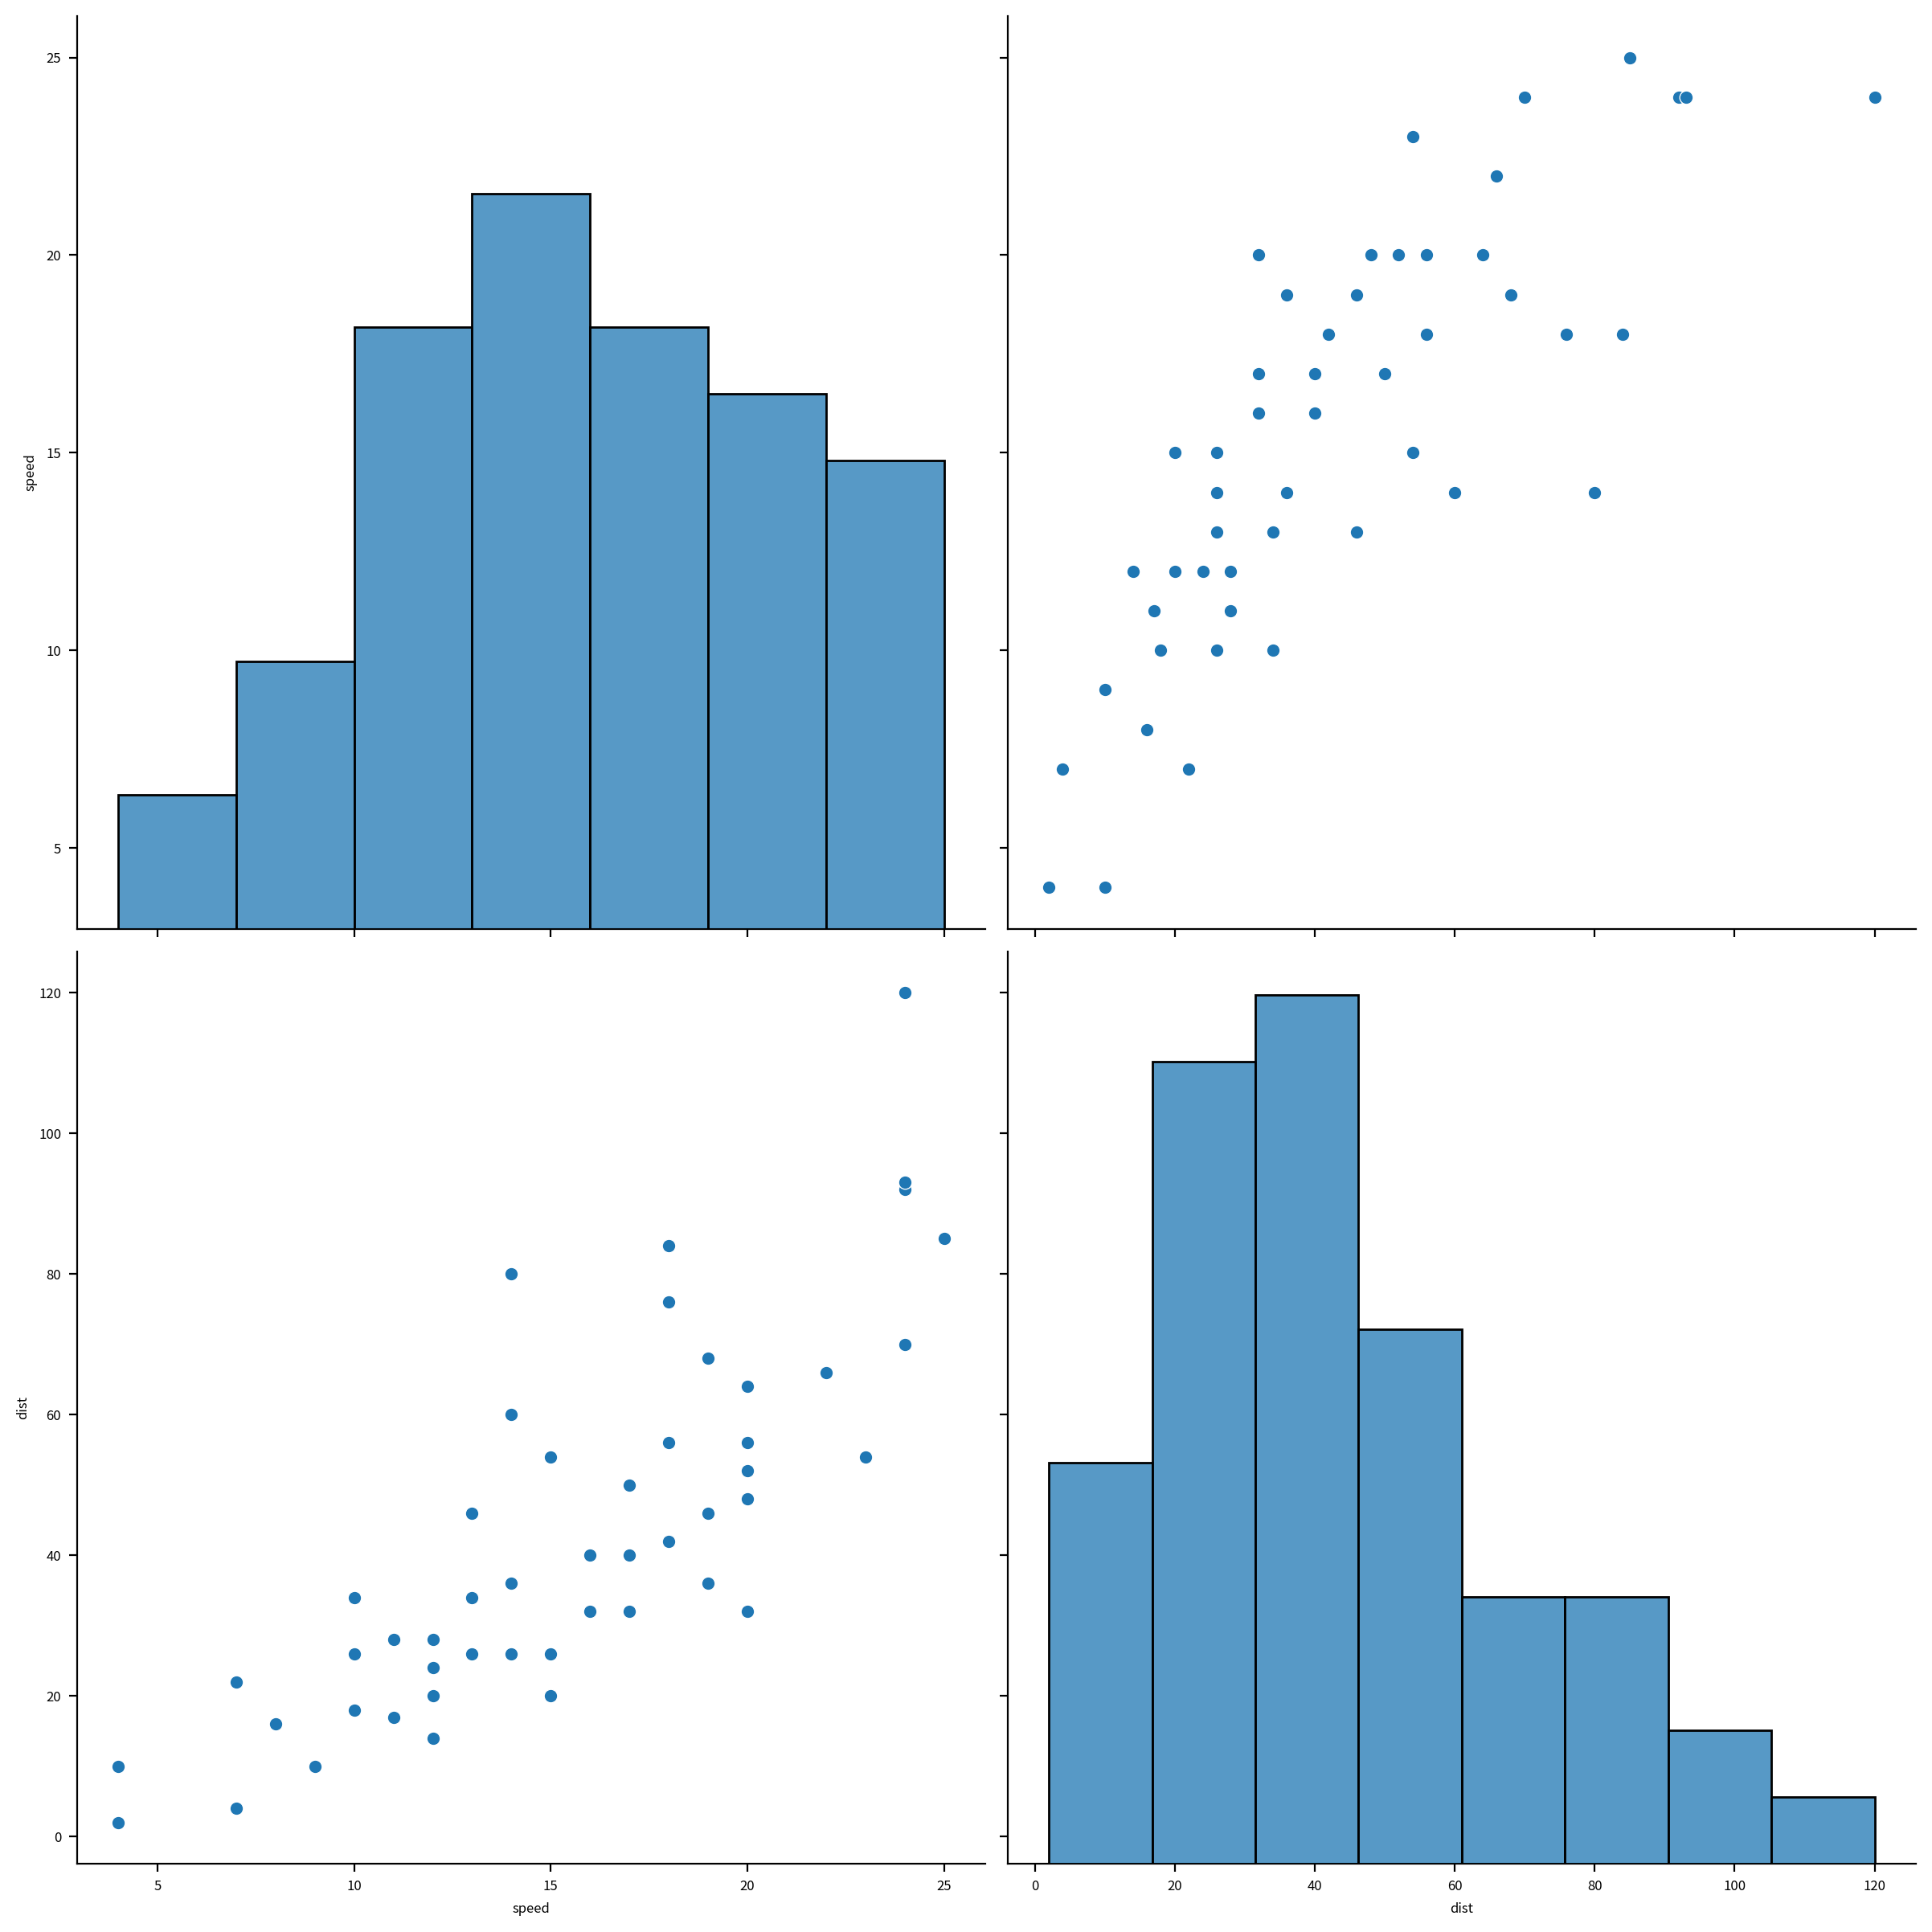

✅ 이상치 요약


,original_skew,log_skew,outliers(|z|>3)
speed,-0.117510,-1.668586,0.0
dist,0.806895,-1.384501,1.0


🎈 상관 분석


,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,speed,dist,True,True,spearman,0.830357,8.824558e-14,True,Very Strong


📊 상관 행렬


,dist,speed
dist,1.000000,0.830357
speed,0.830357,1.000000


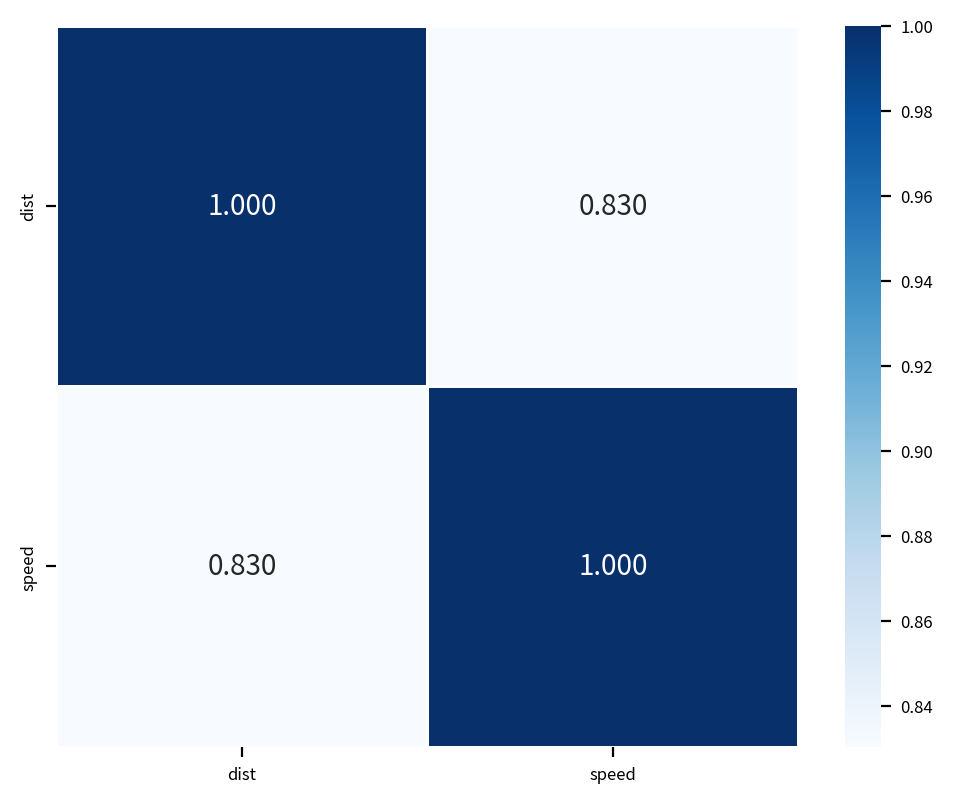

In [9]:
# 데이터 입력
df=origin.filter(['speed','dist'])

# 패키지 참조
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

# 페어플롯으로 형태 확인
width_px=2400
height_px=2400
figsize=(width_px/my_dpi, height_px/my_dpi)

g=sb.pairplot(df, diag_kind='hist')
g.fig.set_size_inches(figsize)
g.fig.set_dpi(my_dpi)
plt.tight_layout()
plt.show()
plt.close()

# 이상치 요약
print('='*50)
print('✅ 이상치 요약')
print('='*50)
skew_outlier={}
for col in df.columns:
    temp=df[col].dropna()
    skew_original=temp.skew()
    z_scores=zscore(temp)
    outlier_count=int(np.sum(np.abs(z_scores)>3))

    data_log=np.log1p(temp-temp.min()+1)
    skew_log=data_log.skew()
    skew_outlier[col]={
        'original_skew':skew_original,
        'log_skew':skew_log,
        'outliers(|z|>3)':outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
display(skew_outlier_df)

# 상관 분석
print('='*50)
print('🎈 상관 분석')
print('='*50)
rows=[]
for a, b in combinations(df.columns, 2):
    x=df[a]
    y=df[b]
    X=sm.add_constant(x)
    model=sm.OLS(y,X).fit()
    reset=linear_reset(model, power=2, use_f=True)
    linearity_ok=reset.pvalue>0.05
    a_flag=skew_outlier_df.loc[a, 'outliers(|z|>3)']>0
    b_flag=skew_outlier_df.loc[b, 'outliers(|z|>3)']>0
    outlier_flag=a_flag or b_flag
    if linearity_ok and not outlier_flag:
        chosen='pearson'
        corr, pval=pearsonr(x, y)
    else:
        chosen='spearman'
        corr, pval=spearmanr(x, y)
    significant=pval<=0.05
    abs_r=abs(corr)
    if abs_r>=0.80:
        strength='Very Strong'
    elif abs_r>=0.60:
        strength='Strong'
    elif abs_r>=0.40:
        strength='Medium'
    elif abs_r>=0.20:
        strength='Weak'
    else:
        strength='Very Weak'
    rows.append({
        'var_a':a,
        'var_b':b,
        'linearity':linearity_ok,
        'outlier_flag':outlier_flag,
        'chosen':chosen,
        'corr':corr,
        'pval':pval,
        'significant':significant,
        'strength':strength
    })
summary_df=DataFrame(rows)
display(summary_df)

# 상관 행렬
print('='*50)
print('📊 상관 행렬')
print('='*50)
vars=sorted(set(summary_df['var_a']).union(summary_df['var_b']))
corr_matrix=DataFrame(np.nan, index=vars, columns=vars)
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a,b]=r
    corr_matrix.loc[b,a]=r
np.fill_diagonal(corr_matrix.values,1)
display(corr_matrix)

# 상관행렬 시각화
width_px=1000
height_px=800
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues', annot_kws={'size':10})
plt.tight_layout()
plt.show()
plt.close()

In [10]:
x=origin[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [11]:
y=origin['dist']
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

In [12]:
X=sm.add_constant(x)
X.head()

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8


In [13]:
model=sm.OLS(y,X)
fit=model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        10:52:08   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

In [14]:
model=ols('dist ~ speed', data=origin)
fit=model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        10:52:42   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

In [17]:
df=origin.copy()
df['y_pred']=fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [18]:
df_melt=df.melt(
    id_vars='speed',
    value_vars=['dist','y_pred'],
    var_name='variable',
    value_name='value'
)

df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


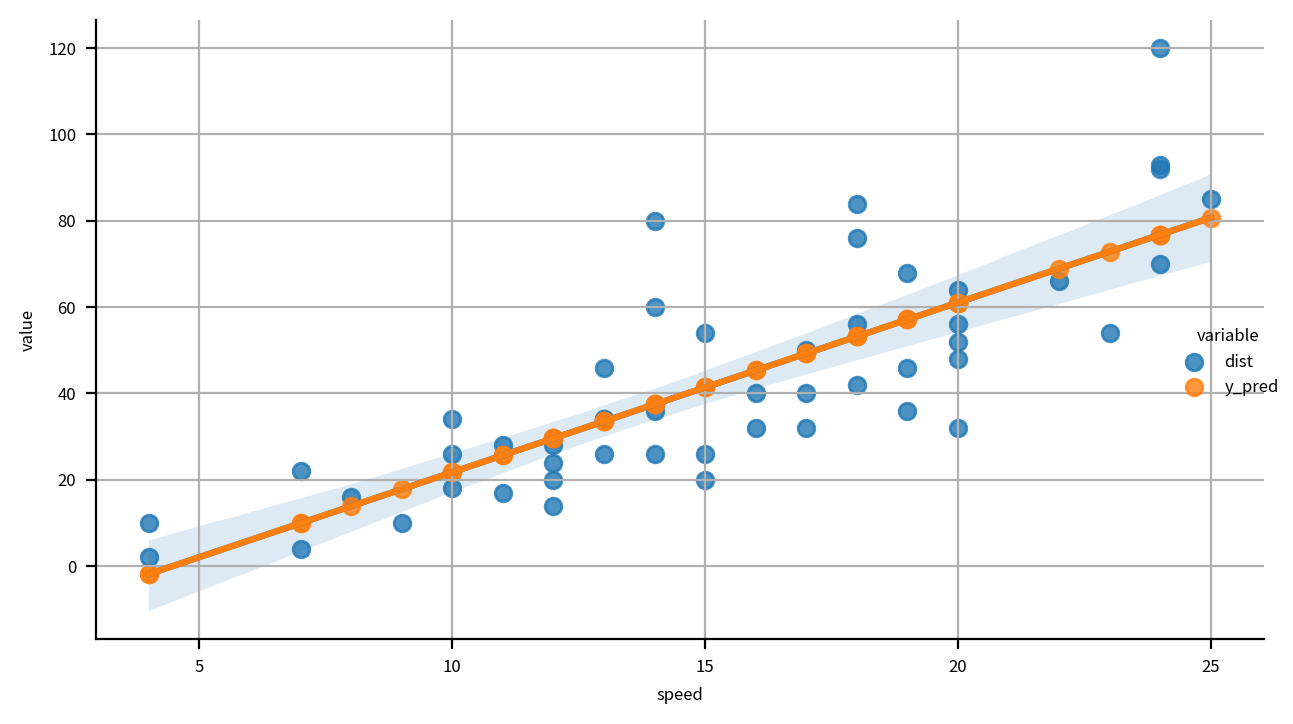

In [19]:
width_px=1280
height_px=720
figsize=(width_px/my_dpi, height_px/my_dpi)

g=sb.lmplot(data=df_melt, x='speed', y='value', hue='variable')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

plt.tight_layout()
plt.show()
plt.close()